In [1]:
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
root_path = './Shoe vs Sandal vs Boot Dataset'

class_names = os.listdir(root_path)
print(f"Class Names: {class_names}")

n_classes = len(class_names)
print(f"Number of Classes: {n_classes}")

class_dis = [len (os.listdir(os.path.join(root_path, class_name))) for class_name in class_names]
print(f"Class Distribution: {class_dis}")

Class Names: ['Boot', 'Shoe', 'Sandal']
Number of Classes: 3
Class Distribution: [5000, 5000, 5000]


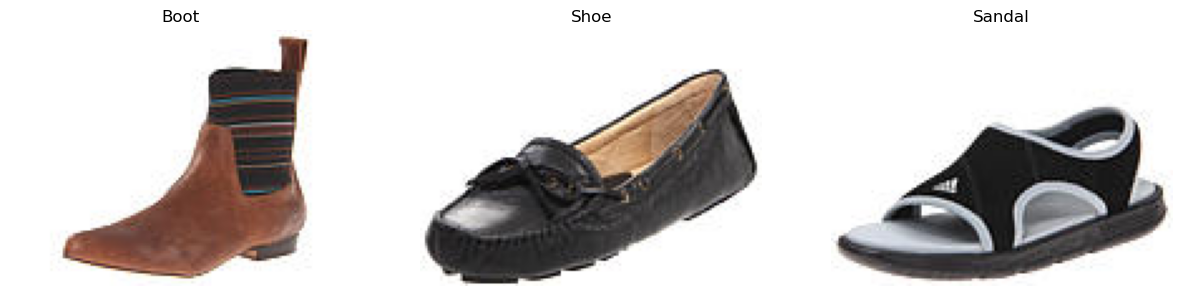

In [4]:
fig, ax = plt.subplots(1, n_classes, figsize=(15, 15))
for i, class_name in enumerate(class_names):
    img_path = os.path.join(root_path, class_name, os.listdir(os.path.join(root_path, class_name))[0])
    img = mpimg.imread(img_path)
    ax[i].imshow(img)
    ax[i].set_title(class_name)
    ax[i].axis('off')
plt.show()

In [5]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

datasets = datasets.ImageFolder(root_path, transform=transform)
print(f"Number of Images: {len(datasets)}")

train_size = int(0.6 * len(datasets))
val_size = int(0.1 * len(datasets))
test_size = len(datasets) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(datasets, [train_size, val_size, test_size])

print(f"\nNumber of Training Images: {len(train_set)}")
print(f"Number of Validation Images: {len(val_set)}")
print(f"Number of Testing Images: {len(test_set)}")


train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

Number of Images: 15000

Number of Training Images: 9000
Number of Validation Images: 1500
Number of Testing Images: 4500


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(150*150*3, 40),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(40, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer_stack(x)
        return x

model_mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-4)
print(f"Number of Parameters: {sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)}")

Number of Parameters: 2700747


In [7]:
def train_model(dataLoader, model, criterion, optimizer, n_epochs=10):
    avg_train_loss = 0
    accuracy = 0
    avg_val_loss = 0
    model.train()
    for epoch in range(n_epochs):
        train_loss_epoch = 0
        val_loss_epoch = 0
        accuracy = 0
        for images, labels in dataLoader['train']:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()

        model.eval()
        with torch.no_grad():
            for images, labels in dataLoader['val']:
                output = model(images)
                loss = criterion(output, labels)
                val_loss_epoch += loss.item()
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        avg_train_loss = train_loss_epoch/len(dataLoader['train'])
        avg_val_loss = val_loss_epoch/len(dataLoader['val'])

        print(f"Epoch {epoch+1}/{n_epochs}.. "
                f"Train loss: {avg_train_loss:.3f}.. "
                f"Val loss: {avg_val_loss:.3f}.. "
                f"Val accuracy: {accuracy/len(dataLoader['val']):.3f}")
    return avg_train_loss, avg_val_loss

In [8]:
def test_model(dataLoader, model, criterion):
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataLoader['test']:
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    print(f"Test loss: {test_loss/len(dataLoader['test']):.3f}.. "
            f"Test accuracy: {accuracy/len(dataLoader['test']):.3f}")
    return test_loss/len(dataLoader['test']), accuracy/len(dataLoader['test'])

In [9]:
# def plot_loss(train_loss, val_loss):
#     plt.plot(train_loss, label='Training loss')
#     plt.plot(val_loss, label='Validation loss')
#     plt.legend(frameon=False)
#     plt.show()

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='MLP_Board')
dataLoader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
train_loss, val_loss = train_model(dataLoader, model_mlp, criterion, optimizer, n_epochs=10)
# plot_loss(train_loss, val_loss)


Epoch 1/10.. Train loss: 0.879.. Val loss: 0.716.. Val accuracy: 0.839
Epoch 2/10.. Train loss: 0.694.. Val loss: 0.674.. Val accuracy: 0.877
Epoch 3/10.. Train loss: 0.674.. Val loss: 0.664.. Val accuracy: 0.887
Epoch 4/10.. Train loss: 0.658.. Val loss: 0.648.. Val accuracy: 0.908
Epoch 5/10.. Train loss: 0.650.. Val loss: 0.647.. Val accuracy: 0.905
Epoch 6/10.. Train loss: 0.640.. Val loss: 0.640.. Val accuracy: 0.911
Epoch 7/10.. Train loss: 0.634.. Val loss: 0.645.. Val accuracy: 0.907
Epoch 8/10.. Train loss: 0.629.. Val loss: 0.632.. Val accuracy: 0.917
Epoch 9/10.. Train loss: 0.625.. Val loss: 0.629.. Val accuracy: 0.924
Epoch 10/10.. Train loss: 0.625.. Val loss: 0.627.. Val accuracy: 0.925


In [11]:
test_loss, test_accuracy = test_model(dataLoader, model_mlp, criterion)


Test loss: 0.636.. Test accuracy: 0.914


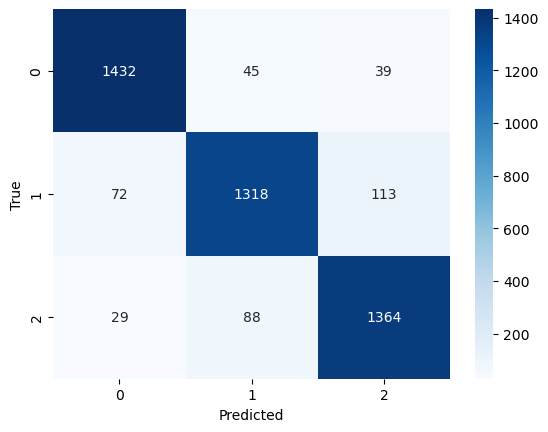

              precision    recall  f1-score   support

        Boot       0.93      0.94      0.94      1516
        Shoe       0.91      0.88      0.89      1503
      Sandal       0.90      0.92      0.91      1481

    accuracy                           0.91      4500
   macro avg       0.91      0.91      0.91      4500
weighted avg       0.91      0.91      0.91      4500



In [12]:
y_true = []
y_pred = []
model_mlp.eval()
with torch.no_grad():
    for images, labels in test_loader:
        output = model_mlp(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        y_true.extend(labels)
        y_pred.extend(top_class.view(-1))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred, target_names=class_names))

In [13]:
torch.save(model_mlp.state_dict(), 'model_mlp.pth')

# CNN

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64*18*18, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x

model_cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-4)
print(f"Number of Parameters: {sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)}")

Number of Parameters: 2678531


In [15]:
writer = SummaryWriter(log_dir='CNN_Board')
dataLoader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
train_loss, val_loss = train_model(dataLoader, model_cnn, criterion, optimizer, n_epochs=10)
# plot_loss(train_loss, val_loss)



Epoch 1/10.. Train loss: 0.669.. Val loss: 0.620.. Val accuracy: 0.937
Epoch 2/10.. Train loss: 0.608.. Val loss: 0.607.. Val accuracy: 0.948
Epoch 3/10.. Train loss: 0.593.. Val loss: 0.587.. Val accuracy: 0.965
Epoch 4/10.. Train loss: 0.580.. Val loss: 0.576.. Val accuracy: 0.979
Epoch 5/10.. Train loss: 0.573.. Val loss: 0.581.. Val accuracy: 0.972
Epoch 6/10.. Train loss: 0.570.. Val loss: 0.580.. Val accuracy: 0.973
Epoch 7/10.. Train loss: 0.568.. Val loss: 0.577.. Val accuracy: 0.975
Epoch 8/10.. Train loss: 0.564.. Val loss: 0.577.. Val accuracy: 0.975
Epoch 9/10.. Train loss: 0.563.. Val loss: 0.576.. Val accuracy: 0.977
Epoch 10/10.. Train loss: 0.559.. Val loss: 0.573.. Val accuracy: 0.983


In [16]:
test_loss, test_accuracy = test_model(dataLoader, model_cnn, criterion)

Test loss: 0.579.. Test accuracy: 0.971


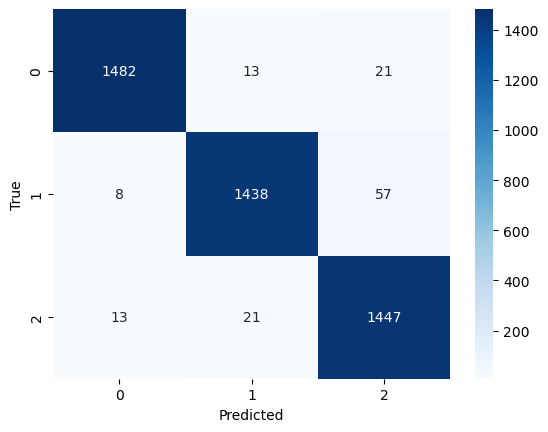

              precision    recall  f1-score   support

        Boot       0.99      0.98      0.98      1516
        Shoe       0.98      0.96      0.97      1503
      Sandal       0.95      0.98      0.96      1481

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500



In [17]:
y_true = []
y_pred = []
model_cnn.eval()
with torch.no_grad():
    for images, labels in test_loader:
        output = model_cnn(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        y_true.extend(labels)
        y_pred.extend(top_class.view(-1))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred, target_names=class_names))



In [18]:

torch.save(model_cnn.state_dict(), 'model_cnn.pth')

compare MLP and CNN

both are used for image classification, but CNN converges faster and has better performance(near 97% accuracy) with same number of parameters and epochs as MLP (near 90% accuracy)


# CNN with block dropout

In [19]:
class blockDropout(nn.Module):
    def __init__(self, p=0.5, block_size=2):
        super().__init__()
        self.p = p
        self.block_size = block_size
        self.stride = (1, 1)
        self.padding = (self.block_size//2, self.block_size//2)
        self.kernel_size = (self.block_size, self.block_size)

    def forward(self, x):
        if not self.training or self.p == 0:
            return x
        else:
            mask = torch.rand(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device) > self.p
            mask = mask.repeat(1, x.shape[1], 1, 1)
            x = x * mask
            return x

In [20]:
class CNN_blockDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),
            blockDropout(block_size=3),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            blockDropout(block_size=3),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            blockDropout(),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*18*18, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x

In [21]:
model_cnn_blockDropout = CNN_blockDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn_blockDropout.parameters(), lr=1e-4)
print(f"Number of Parameters: {sum(p.numel() for p in model_cnn_blockDropout.parameters() if p.requires_grad)}")


Number of Parameters: 2678531


In [22]:
writer = SummaryWriter(log_dir='CNN_blockDropout_Board')
dataLoader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
train_loss, val_loss = train_model(dataLoader, model_cnn_blockDropout, criterion, optimizer, n_epochs=10)
# plot_loss(train_loss, val_loss)



Epoch 1/10.. Train loss: 0.730.. Val loss: 0.645.. Val accuracy: 0.906
Epoch 2/10.. Train loss: 0.641.. Val loss: 0.613.. Val accuracy: 0.937
Epoch 3/10.. Train loss: 0.613.. Val loss: 0.618.. Val accuracy: 0.931
Epoch 4/10.. Train loss: 0.600.. Val loss: 0.603.. Val accuracy: 0.946
Epoch 5/10.. Train loss: 0.592.. Val loss: 0.596.. Val accuracy: 0.956
Epoch 6/10.. Train loss: 0.584.. Val loss: 0.590.. Val accuracy: 0.961
Epoch 7/10.. Train loss: 0.583.. Val loss: 0.591.. Val accuracy: 0.959
Epoch 8/10.. Train loss: 0.576.. Val loss: 0.593.. Val accuracy: 0.957
Epoch 9/10.. Train loss: 0.575.. Val loss: 0.584.. Val accuracy: 0.964
Epoch 10/10.. Train loss: 0.571.. Val loss: 0.580.. Val accuracy: 0.969


In [23]:
test_loss, test_accuracy = test_model(dataLoader, model_cnn_blockDropout, criterion)


Test loss: 0.584.. Test accuracy: 0.966


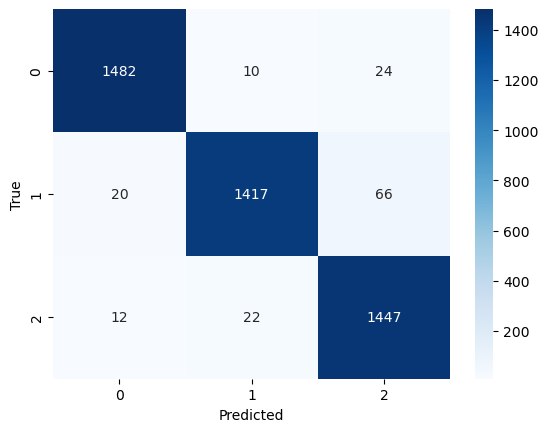

              precision    recall  f1-score   support

        Boot       0.98      0.98      0.98      1516
        Shoe       0.98      0.94      0.96      1503
      Sandal       0.94      0.98      0.96      1481

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97      0.97      0.97      4500



In [24]:
y_true = []
y_pred = []
model_cnn_blockDropout.eval()
with torch.no_grad():
    for images, labels in test_loader:
        output = model_cnn_blockDropout(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        y_true.extend(labels)
        y_pred.extend(top_class.view(-1))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred, target_names=class_names))

In [25]:
torch.save(model_cnn_blockDropout.state_dict(), 'model_cnn_blockDropout.pth')

in dropblockout feature map, we randomly drop out a block of pixels in the feature map, and then we do the convolution on the remaining pixels. This is to prevent the model from overfitting.
when feature are correlated, we can use dropblockout to prevent the model from overfitting.

# CNN with Factorization

In [26]:
class CNN_Factorization(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(16, 16, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),
            blockDropout(block_size=3),

            nn.Conv2d(16, 32, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(32, 32, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            blockDropout(block_size=3),

            nn.Conv2d(32, 64, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(64, 64, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            blockDropout(),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*18*18, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x

In [27]:
model_cnn_factorization = CNN_Factorization()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn_factorization.parameters(), lr=1e-4)
print(f"Number of Parameters: {sum(p.numel() for p in model_cnn_factorization.parameters() if p.requires_grad)}")

Number of Parameters: 2679123


In [28]:
writer = SummaryWriter(log_dir='CNN_Factorization_Board')
dataLoader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
train_loss, val_loss = train_model(dataLoader, model_cnn_factorization, criterion, optimizer, n_epochs=10)

Epoch 1/10.. Train loss: 0.730.. Val loss: 0.665.. Val accuracy: 0.884
Epoch 2/10.. Train loss: 0.652.. Val loss: 0.637.. Val accuracy: 0.912
Epoch 3/10.. Train loss: 0.623.. Val loss: 0.612.. Val accuracy: 0.937
Epoch 4/10.. Train loss: 0.603.. Val loss: 0.598.. Val accuracy: 0.954
Epoch 5/10.. Train loss: 0.599.. Val loss: 0.600.. Val accuracy: 0.951
Epoch 6/10.. Train loss: 0.591.. Val loss: 0.587.. Val accuracy: 0.963
Epoch 7/10.. Train loss: 0.584.. Val loss: 0.597.. Val accuracy: 0.953
Epoch 8/10.. Train loss: 0.582.. Val loss: 0.595.. Val accuracy: 0.955
Epoch 9/10.. Train loss: 0.573.. Val loss: 0.584.. Val accuracy: 0.967
Epoch 10/10.. Train loss: 0.571.. Val loss: 0.585.. Val accuracy: 0.965


In [29]:
test_loss, test_accuracy = test_model(dataLoader, model_cnn_factorization, criterion)

Test loss: 0.589.. Test accuracy: 0.960


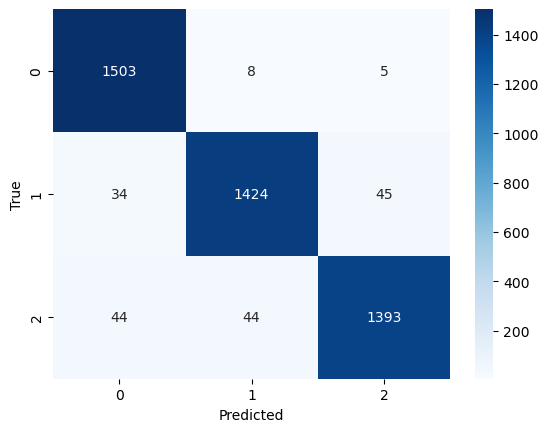

              precision    recall  f1-score   support

        Boot       0.95      0.99      0.97      1516
        Shoe       0.96      0.95      0.96      1503
      Sandal       0.97      0.94      0.95      1481

    accuracy                           0.96      4500
   macro avg       0.96      0.96      0.96      4500
weighted avg       0.96      0.96      0.96      4500



In [30]:

y_true = []
y_pred = []
model_cnn_factorization.eval()
with torch.no_grad():
    for images, labels in test_loader:
        output = model_cnn_factorization(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        y_true.extend(labels)
        y_pred.extend(top_class.view(-1))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred, target_names=class_names))


In [31]:
torch.save(model_cnn_factorization.state_dict(), 'model_cnn_factorization.pth')

# compare num of parameters 
kernel factorization reduces the number of parameters very little and the accuracy is almost the same as the original CNN 
kernel factorization advantage:
1. reduce the number of parameters
2. reduce the number of multiplications


